# Basic causal structures

Understanding basic causal structures is crucial in causal inference because they possess **unique properties** that aid in the discovery of causal graphs from observational data. Additionally, recognizing these structures is essential for correctly specifying **regression models** in statistical analysis. Misidentifying or incorrectly including variables based on these structures can lead to erroneous conclusions and model estimates.

## Chains

A chain occurs when one variable causally affects a second, which in turn affects a third. This linear sequence shows the **transmission of causality** through an intermediary.

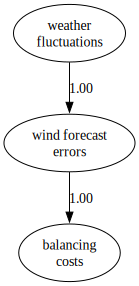

In [1]:
import numpy as np
from lingam.utils import make_dot

# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0]])

# Plotting causal graph
make_dot(m, labels=["weather \nfluctuations", "wind forecast \nerrors", "balancing \ncosts"])

## Forks

A fork occurs when a single variable causally influences two other variables, making it a common cause to both. This structure typically indicates that the two downstream variables are **correlated due to a shared source** but do not causally influence each other. This coincides with the exmaple we saw in the previous chapter, where the common cause (temperature) gave the impression that electricity load and ice cream sales were correlated.

Another example, related to the balancing costs in the electricity markets, might be the effect of weather fluctuations on wind forecast errors and on electricity load due to increase heating (or cooling) demand.

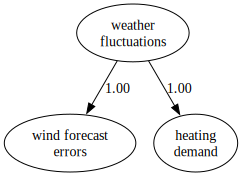

In [2]:
# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [1.0, 0.0, 0.0],
              [1.0, 0.0, 0.0]])

# Plotting causal graph
make_dot(m, labels=["weather \nfluctuations", "wind forecast \nerrors", "heating \ndemand"])

## Immoralities

An immorality happens when two variables independently cause a third variable, but there is no causal connection between the two independent variables. Conditioning on the common effect (**collider**) can introduce a **spurious association** between these independent variables.

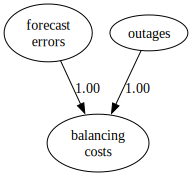

In [3]:
# Matrix of coefficients (weights)
m = np.array([[0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0],
              [1.0, 1.0, 0.0]])

# Plotting causal graph
make_dot(m, labels=["forecast \nerrors", "outages", "balancing \ncosts"])

We will now see the effect of the **Berkson's paradox**, which is the spurious correlation observed in the two parent variables, after conditioning on the collider.

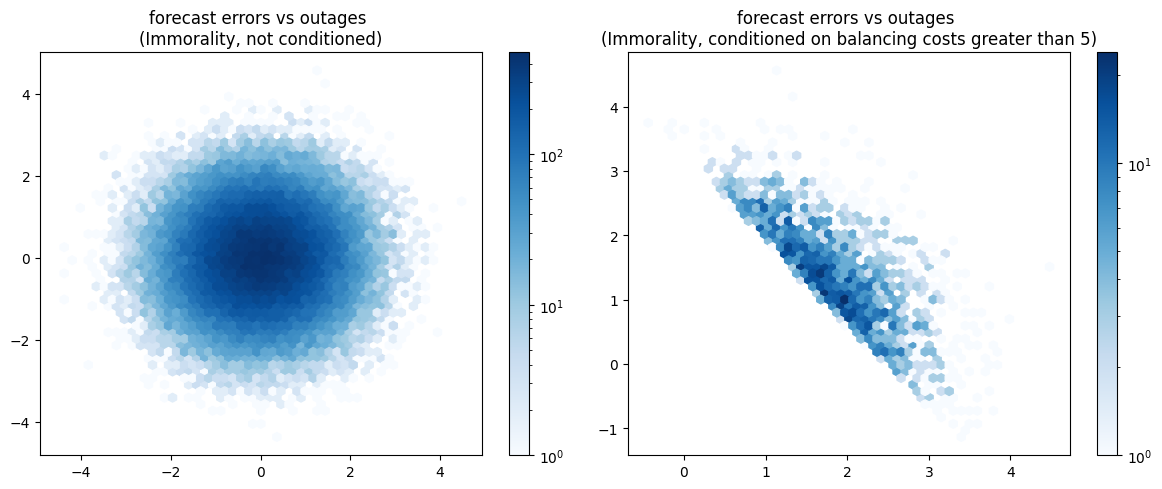

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(42)

# Generate data for the Immorality example
n = 100000
forecast_errors = np.random.normal(0, 1, n)
outages = np.random.normal(0, 1, n)
balancing_costs = 2 * forecast_errors + 1.5 * outages + np.random.normal(0, .1, n)  # the collider

data_immorality = pd.DataFrame({'forecast errors': forecast_errors, 'outages': outages, 'balancing costs': balancing_costs})

# Setting up the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# All the data
hb1 = axes[0].hexbin(data_immorality['forecast errors'], data_immorality['outages'], gridsize=50, cmap='Blues', bins='log')
cb1 = fig.colorbar(hb1, ax=axes[0])
axes[0].set_title('forecast errors vs outages \n(Immorality, not conditioned)')

# After conditioning
data_immorality_conditioned = data_immorality[data_immorality['balancing costs'] >= 5]
hb2 = axes[1].hexbin(data_immorality_conditioned['forecast errors'], data_immorality_conditioned['outages'], gridsize=50, cmap='Blues', bins='log')
cb2 = fig.colorbar(hb2, ax=axes[1])
axes[1].set_title('forecast errors vs outages \n(Immorality, conditioned on balancing costs greater than 5)')

plt.tight_layout()

We can observe how conditioning on a collider introduces spurious correlations in the data. This underscores the importance of being cautious when attempting to draw causal conclusions from observational data. 

**In practice**, this means that merely including the collider as a predictor in a **regression model** can lead to misleading results, where the estimated coefficients deviate significantly from the true causal effects. This potential misstep highlights the necessity of carefully selecting variables for inclusion in regression models, especially when the goal is to uncover causal relationships rather than mere associations.

### Structural causal model (SCM)

In the above example, we generated data from the causal graph representing the immorality. However, to generate observations, we assumed knowledge about the **structural equations** governing the system. Which, in that case, were given by:

\begin{align}
    \text{forecast errors} &= \mathcal{N}(0,1) \\
    \text{outages} &= \mathcal{N}(0,1) \\
    \text{balancing costs} &= 2 \times \text{forecast errors} + 1.5 \times \text{outages} + \mathcal{N}(0, 0.1) \\
\end{align}

This is the **structural causal model (SCM)**, from which we can see how wind energy and outdated grid are not causally related.